In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, StratifiedKFold, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error

import itertools as it

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import time as time

In [ ]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [ ]:
y_train = y_train['profitable']
y_test = y_test['profitable']
X_train = X_train.drop(columns = "Unnamed: 0")
X_test = X_test.drop(columns = "Unnamed: 0")

In [ ]:
start_time = time.time()

params = {'n_estimators': [1000, 1500],
          'max_features': range(1,9),
          'max_depth': range(8, 20, 4),
          'max_leaf_nodes': range(30, 60, 4)
         }

param_list=list(it.product(*(params[Name] for Name in list(params.keys()))))
oob_accuracy = [0]*len(param_list)

i=0
for pr in param_list:
    model = RandomForestClassifier(random_state=1,
                                   oob_score=True,
                                   verbose=False,
                                   n_estimators = pr[0],
                                   max_features=pr[1], 
                                   max_depth=pr[2], 
                                   max_leaf_nodes=pr[3], 
                                   n_jobs=-1).fit(X_train,y_train)
    oob_accuracy[i] = model.oob_score_
    i=i+1
    
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("max accuracy = ", np.max(oob_accuracy))
print("params= ", param_list[np.argmax(oob_recall)])

time taken =  51.60229480266571  minutes
max accuracy =  0.7809438112377525
params=  (1500, 3, 8, 58)


In [ ]:
model = RandomForestClassifier(random_state=1,
                                   oob_score=True,
                                   verbose=False,
                                   n_estimators = 1500,
                                   max_features=3, 
                                   max_depth=8, 
                                   max_leaf_nodes=58, 
                                   n_jobs=-1).fit(X_train,y_train)
    

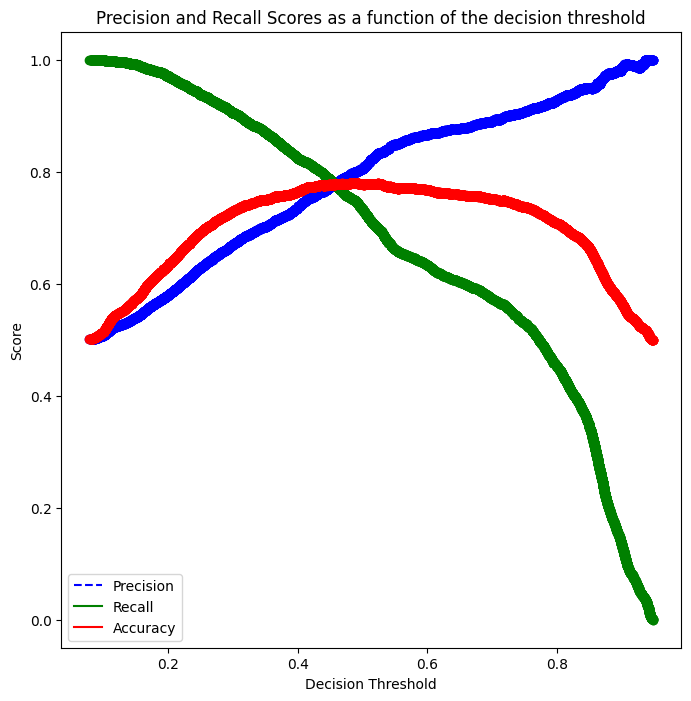

In [ ]:
y_pred_prob = model.oob_decision_function_[:,1]
p, r, thresholds = precision_recall_curve(y_train, y_pred_prob)
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = y_pred_prob > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [ ]:
# Thresholds with precision and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), acc.reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_60 = all_thresholds[all_thresholds[:,2]>0.6,:]
# As the values in 'recall_more_than_80' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probabiltiy for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_60[recall_more_than_60.shape[0]-1]

array([0.65664355, 0.75794841, 0.60003994])

Accuracy:  76.76464707058588
ROC-AUC:  0.8731209480130151
Precision:  0.8923976608187134
Recall:  0.6094249201277955


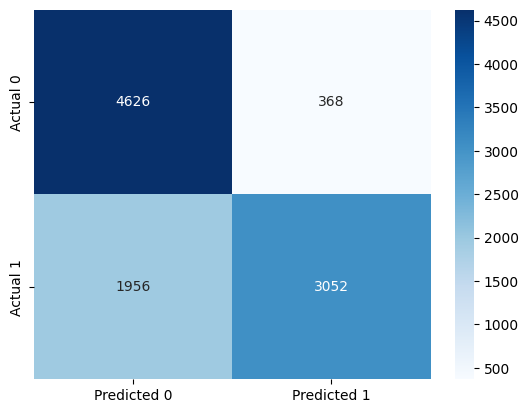

In [ ]:
# train

# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.65664355

y_pred_prob = model.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  76.16081540203851
ROC-AUC:  0.8614552870555641
Precision:  0.8942807625649913
Recall:  0.589041095890411


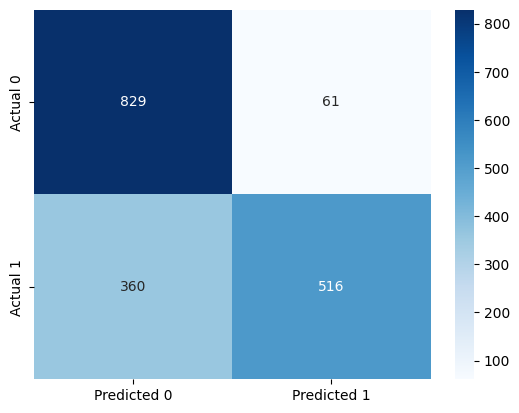

In [ ]:
# test

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [ ]:
# better attempt ..?